<a href="https://colab.research.google.com/github/DJCordhose/llm-ops/blob/main/Past.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SetFit (Sentence Transformer Fine-tuning): Efficient Few-Shot Learning Without Prompts

## Options
1. Training on GPU, inference on GPU
1. Training on GPU, inference on CPU (recommended)
1. Training on CPU, inference on CPU (training can be a slow, depending on model)

## How it works
1. fine-tuning a pretrained Sentence Transformers (ST) on a small number of text pairs, in a contrastive Siamese manner
1. training a classifier head on the embeddings generated from the fine-tuned ST

![](https://raw.githubusercontent.com/huggingface/setfit/main/assets/setfit.png)

## Detailed steps of of contrastive Siamese training for fine-tuning

1. **Embedding Generation**: The input data is passed through a pretrained transformer model, like Sentence-BERT or RoBERTa, to generate embeddings. These embeddings are vector representations of the text data, capturing the semantic nuances in a high-dimensional space.

1. **Contrastive Loss Calculation**: In contrastive training, the goal is to adjust the embeddings so that similar texts (texts with the same label) are closer together in the embedding space, and dissimilar texts (texts with different labels) are farther apart. Involves pairs of texts, where the model tries to minimize the distance between pairs of similar texts while ensuring that pairs of dissimilar texts are separated by at least a margin.

1. **Model Training**: The model is trained by optimizing this contrastive loss across all selected texts in the dataset. During training, the parameters of the model (or a portion of the model if using fine-tuning) are adjusted to reduce the loss, thereby learning to generate embeddings that effectively group similar texts together and push dissimilar texts apart.

1. **Outcome**: After this step, the model produces high-quality embeddings that are more useful for the specific classification or analysis tasks because they better represent the differences and similarities as per the task-specific data.

This contrastive training step effectively leverages a small amount of labeled data to teach the model a nuanced understanding of the task at hand, setting a strong foundation for the subsequent fine-tuning steps. This makes SetFit particularly powerful in scenarios where labeled data is scarce but quality embeddings are crucial for performance.

## Links
* Intrduction: https://huggingface.co/blog/setfit
* This code mostly taken from: https://huggingface.co/docs/setfit/quickstart
* Sources with technical details: https://github.com/huggingface/setfit
  * notebooks: https://github.com/huggingface/setfit/tree/main/notebooks
* Conceptual Guide: https://huggingface.co/docs/setfit/conceptual_guides/setfit  
* Paper [2209.11055] Efficient Few-Shot Learning Without Prompts: https://arxiv.org/abs/2209.11055
* https://sbert.net/


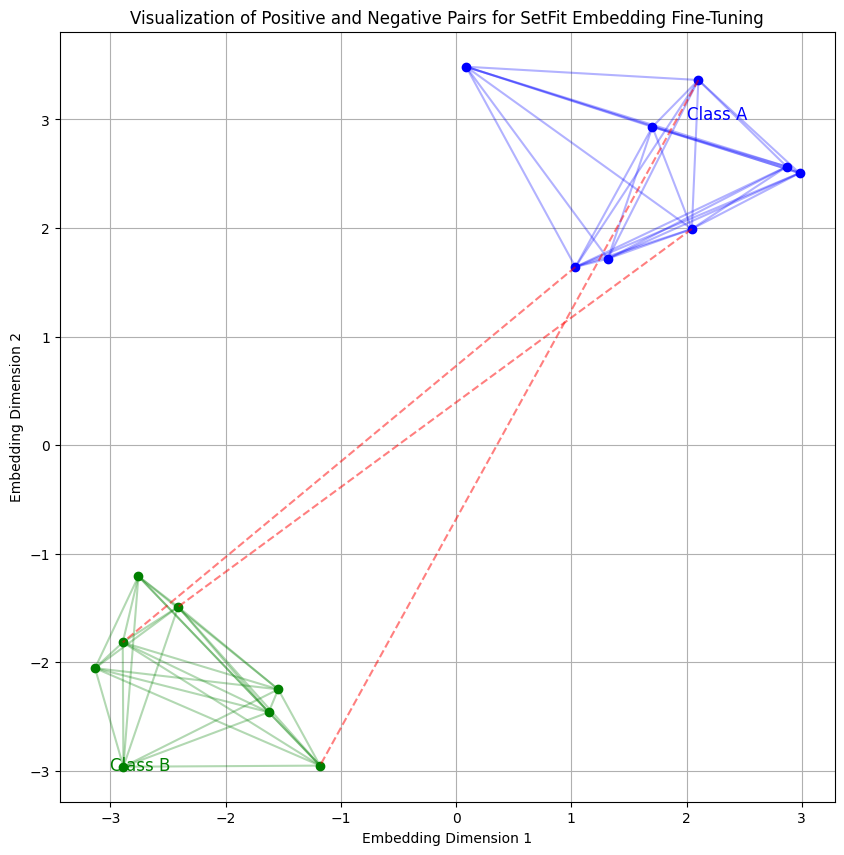

In [1]:
# Generated by https://chatgpt.com/share/671fbe7c-5c20-8009-8f75-fbaecaff323e

import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# Number of samples per class
num_samples = 8

# Generate dummy embeddings (2D for visualization)
class_a_points = np.random.randn(num_samples, 2) + np.array([2, 2])
class_b_points = np.random.randn(num_samples, 2) + np.array([-2, -2])

# Set up plot
fig, ax = plt.subplots(figsize=(10, 10))

# Plot samples for Class A
for point in class_a_points:
    ax.plot(point[0], point[1], 'o', color='blue')
ax.text(2, 3, 'Class A', color='blue', fontsize=12)

# Plot samples for Class B
for point in class_b_points:
    ax.plot(point[0], point[1], 'o', color='green')
ax.text(-3, -3, 'Class B', color='green', fontsize=12)

# Create positive pairs within Class A (Blue Lines)
for pair in combinations(class_a_points, 2):
    ax.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'b-', alpha=0.3)

# Create positive pairs within Class B (Green Lines)
for pair in combinations(class_b_points, 2):
    ax.plot([pair[0][0], pair[1][0]], [pair[0][1], pair[1][1]], 'g-', alpha=0.3)

# Add illustrative contrasting lines between some points in Class A and Class B (Negative Pairs)
for i in range(3):  # Illustrate a few negative pairs
    ax.plot([class_a_points[i][0], class_b_points[i][0]],
            [class_a_points[i][1], class_b_points[i][1]], 'r--', alpha=0.5)

# Set plot title and axis labels
ax.set_title('Visualization of Positive and Negative Pairs for SetFit Embedding Fine-Tuning')
ax.set_xlabel('Embedding Dimension 1')
ax.set_ylabel('Embedding Dimension 2')

# Display plot
plt.grid(True)
plt.show()


In [2]:
!nvidia-smi

Mon Oct 28 17:43:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   63C    P0              31W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip install -q setfit

In [4]:
import setfit
setfit.__version__

'1.1.0'

# Data

In [5]:
positive_en = [
  "With the diagnosis named here, the need for compensation to ensure the basic need is conceivable.",
  "The socio-medical prerequisites for the prescribed aid supply have been met.",
  "Everyday relevant usage benefits have been determined.",
  "Socio-medical indication for the aid is confirmed.",
  "Contraindications have been excluded; there are no contraindications for the use of the requested aid."
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
negative_en = [
  "No specific findings can be derived from the diagnosis currently named as the basis for the regulation.",
  "According to the service extracts from the health insurance, the insured has already been provided with the functional product requested according to its area of application.",
  "A medically comprehensible explanation as to why the use of an orthopedic aid corresponding to the findings is not sufficient and instead electric foot lifter stimulation for walking would be more appropriate and therefore necessary has not been transmitted.",
  "From an overall view of the information available here, it cannot be seen how the supply of the insured with the product could be justified, nor can the safety of such a supply be confirmed.",
  "A medical justification for why a product not listed in the directory of aids should be used in the present case has not been transmitted."
]

In [7]:
positive_de = [
  "Bei der hier benannten Diagnose ist das Erfordernis eines Ausgleichs zur Sicherstellung des Grundbedürfnisses denkbar.",
  "Die sozialmedizinischen Voraussetzungen für die verordnete Hilfsmittelversorgung sind erfüllt.",
  "Alltagsrelevante Gebrauchsvorteile werden festgestellt.",
  "Sozialmedizinische Indikation für das Hilfsmittel wird bestätigt.",
  "Kontraindikationen wurden ausgeschlossen, es liegen keine Gegenanzeigen für die Verwendung des beantragten Hilfsmittels vor."
]

In [8]:
negative_de = [
  "Aus der aktuell als verordnungsbegründend benannten Diagnose lässt sich kein konkreter Befund ableiten.",
  "Gemäß den Leistungsauszügen der Krankenkasse ist der Versicherte bereits entsprechend dem Einsatzbereich des beantragten funktionellen Produkt versorgt.",
  "Eine medizinisch nachvollziehbare Begründung, weshalb der Einsatz einer befundadäquaten orthopädietechnischen Hilfsmittelversorgung nicht ausreichend und stattdessen eine elektrische Fußheberstimulation zum Gehen zweckmäßiger und deshalb notwendig wäre, wurde nicht übermittelt.",
  "In der Gesamtschau der hier vorliegenden Informationen kann nicht erkannt werden, wie die Versorgung des Versicherten mit dem Produkt begründet werden könnte, noch kann die Unbedenklichkeit einer solchen Versorgung bestätigt werden.",
  "Eine ärztliche Begründung, warum im vorliegenden Fall ein nicht im Hilfsmittelverzeichnis gelistetes Produkt zum Einsatz kommen soll, wird nicht übermittelt."
]

In [9]:
lang = "en"
# lang = "de"

In [10]:

if lang == "de":
  negative = negative_de
  positive = positive_de
else:
  negative = negative_en
  positive = positive_en

In [11]:
from datasets import Dataset
ds = Dataset.from_dict({"text": positive + negative, "label": len(positive) * [1] + len(negative) * [0]})
# ds.to_list()

In [12]:
from setfit import sample_dataset

# how many samples do we want for the training per class, we can have up to 5,
# but remember we need some for validation
num_samples_per_class = 3
# num_samples_per_class = 4

train_dataset = sample_dataset(ds, label_column="label", num_samples=num_samples_per_class)
train_dataset.to_list()

[{'text': 'A medically comprehensible explanation as to why the use of an orthopedic aid corresponding to the findings is not sufficient and instead electric foot lifter stimulation for walking would be more appropriate and therefore necessary has not been transmitted.',
  'label': 0},
 {'text': 'With the diagnosis named here, the need for compensation to ensure the basic need is conceivable.',
  'label': 1},
 {'text': 'Everyday relevant usage benefits have been determined.',
  'label': 1},
 {'text': 'Socio-medical indication for the aid is confirmed.', 'label': 1},
 {'text': 'According to the service extracts from the health insurance, the insured has already been provided with the functional product requested according to its area of application.',
  'label': 0},
 {'text': 'No specific findings can be derived from the diagnosis currently named as the basis for the regulation.',
  'label': 0}]

# Few Shot Training

In [13]:
%%time

from setfit import SetFitModel
# model_id = "BAAI/bge-small-en-v1.5"
model_id = "BAAI/bge-m3"  # multi lingual, no fun without GPU
model = SetFitModel.from_pretrained(model_id)
model.labels = ["negative", "positive"]

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


CPU times: user 2.48 s, sys: 611 ms, total: 3.09 s
Wall time: 7.84 s


In [14]:
!nvidia-smi

Mon Oct 28 17:44:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   62C    P0              31W /  72W |   2377MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [15]:
# workaround for report_to=None in the code below not working
# would otherwise try to log to weights and biases server, but we don't have or need one
import os
os.environ["WANDB_DISABLED"] = "true"

In [16]:
from setfit import Trainer, TrainingArguments

args = TrainingArguments(
    batch_size=16, # even though we have less samples, this makes sense - we train on unique pairs
    num_epochs=2, # Number of epochs to use for contrastive learning
    num_iterations=20, # Number of text pairs to generate for contrastive learning
    report_to=None
)

# https://github.com/huggingface/setfit/issues/512#issuecomment-2118679266
args.eval_strategy = args.evaluation_strategy

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Map:   0%|          | 0/6 [00:00<?, ? examples/s]

In [17]:
%%time

# bge-small does train on CPU, takes 1.5 minutes for one epoch
# bge-m3 should be trained in GPU, because it might take up 10 minutes per epoch on CPU
trainer.train()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
***** Running training *****
  Num unique pairs = 240
  Batch size = 16
  Num epochs = 2


Step,Training Loss,Validation Loss


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

CPU times: user 21.4 s, sys: 12.8 s, total: 34.2 s
Wall time: 47.3 s


In [18]:
trainer.evaluate(train_dataset)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
***** Running evaluation *****


{'accuracy': 1.0}

In [19]:
trainer.evaluate(ds)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
***** Running evaluation *****


{'accuracy': 0.9}

# Trying it out

In [20]:
negative

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['No specific findings can be derived from the diagnosis currently named as the basis for the regulation.',
 'According to the service extracts from the health insurance, the insured has already been provided with the functional product requested according to its area of application.',
 'A medically comprehensible explanation as to why the use of an orthopedic aid corresponding to the findings is not sufficient and instead electric foot lifter stimulation for walking would be more appropriate and therefore necessary has not been transmitted.',
 'From an overall view of the information available here, it cannot be seen how the supply of the insured with the product could be justified, nor can the safety of such a supply be confirmed.',
 'A medical justification for why a product not listed in the directory of aids should be used in the present case has not been transmitted.']

In [21]:
model.predict(negative)

['negative', 'negative', 'negative', 'negative', 'negative']

In [22]:
positive

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['With the diagnosis named here, the need for compensation to ensure the basic need is conceivable.',
 'The socio-medical prerequisites for the prescribed aid supply have been met.',
 'Everyday relevant usage benefits have been determined.',
 'Socio-medical indication for the aid is confirmed.',
 'Contraindications have been excluded; there are no contraindications for the use of the requested aid.']

In [23]:
model.predict(positive)

['positive', 'positive', 'positive', 'positive', 'negative']

In [24]:
%%time

# give it a shot, what is your example
model.predict([
    "Give them what they want.",
    "They get nothing",
    "Are you kidding me?"
])

CPU times: user 35.5 ms, sys: 439 µs, total: 36 ms
Wall time: 34.2 ms


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['positive', 'negative', 'negative']

In [28]:
!nvidia-smi

Mon Oct 28 17:47:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   68C    P0              33W /  72W |  12535MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [29]:
raise Exception("Stopping execution here - continue after this cell if you want to save/load the trained model")

Exception: Stopping execution here

# Saving model

In [ ]:
model_name = "setfit-bge-small-v1.5-sst2-8-shot"

In [ ]:
model.save_pretrained(model_name)

In [ ]:
!ls -lh {model_name}

In [ ]:
# download to local machine
!tar czvf {model_name}.tgz {model_name}

# In case you were training on GPU: Loading onto CPU and making inferences

**Only if you were training on GPU and want to try inference on CPU**: Switch to CPU (which also restarts the runtime), upload the tgz saved before and execute *only the following* on CPU

In [ ]:
model_name = "setfit-bge-small-v1.5-sst2-8-shot"

In [ ]:
!tar xzvf {model_name}.tgz

In [ ]:
!ls -lh {model_name}

In [ ]:
!pip install -q setfit

In [ ]:
from setfit import SetFitModel

model = SetFitModel.from_pretrained(model_name)

In [ ]:
%%time

# give it a shot, what is your example
model.predict([
    "Give them what they want.",
    "They get nothing",
    "Are you kidding me?"
])